## 1) Load helper extractor class to process data for London only

In [6]:
from src.LondonExtractor import LondonFilter

In [7]:
filterer = LondonFilter(input_dir="./data/", output_path="./data/london.csv")
filterer.process()

Filtered London data saved to: ./data/london.csv


## 2) Read in London dataset

In [1]:
import pandas as pd

In [2]:
london_df = pd.read_csv("./data/london.csv")

In [3]:
# Convert to datetime
london_df['transfer_date'] = pd.to_datetime(london_df['transfer_date'], errors='coerce')

# Extract year
london_df['year'] = london_df['transfer_date'].dt.year

# Value counts by year
london_df['year'].value_counts().sort_index()


year
2018    67138
2019    64677
2020    59624
2021    85207
2022    75127
2023    58875
2024    57204
2025    16270
Name: count, dtype: int64

In [4]:
london_df

,transaction_id,price,transfer_date,postcode,property_type,old_new,duration,paon,saon,street,locality,town,district,county,ppd_category,record_status,year
0,{75050A85-94A5-9A88-E053-6B04A8C02390},545000,2018-08-24,SW17 0PS,T,N,F,137,NaN,STRATHDON DRIVE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
1,{75050A85-94A9-9A88-E053-6B04A8C02390},480000,2018-07-06,SW2 3TP,F,N,L,64,NaN,WYATT PARK ROAD,NaN,LONDON,LAMBETH,GREATER LONDON,A,A,2018
2,{75050A85-94AD-9A88-E053-6B04A8C02390},415000,2018-08-13,SW14 7LR,F,N,L,HUNTINGDON COURT,FLAT 12,LITTLE ST LEONARDS,NaN,LONDON,RICHMOND UPON THAMES,GREATER LONDON,A,A,2018
3,{75050A85-94AE-9A88-E053-6B04A8C02390},2765000,2018-07-18,SW15 6AL,D,N,F,57,NaN,ST JOHNS AVENUE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
4,{75050A85-94B2-9A88-E053-6B04A8C02390},750000,2018-08-07,SW17 0NP,T,N,F,694,NaN,GARRATT LANE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484117,{38EDC0C3-613C-0F63-E063-4704A8C00424},446000,2025-05-02,SW12 8NY,F,N,L,56,FLAT 1,NIGHTINGALE LANE,NaN,LONDON,WANDSWORTH,GREATER LONDON,A,A,2025
484118,{38EDC0C3-613D-0F63-E063-4704A8C00424},380000,2025-05-16,E15 2GB,F,N,L,"OPAL COURT, 172",76,HIGH STREET,STRATFORD,LONDON,NEWHAM,GREATER LONDON,A,A,2025
484119,{38EDC0C3-613E-0F63-E063-4704A8C00424},500000,2025-03-31,SE23 1BF,S,N,F,4,NaN,BEAUMARIS MEWS,NaN,LONDON,LEWISHAM,GREATER LONDON,A,A,2025
484120,{38EDC0C3-613F-0F63-E063-4704A8C00424},685000,2025-05-22,SW4 8BQ,F,N,L,36,FLAT 2,KINGS AVENUE,NaN,LONDON,LAMBETH,GREATER LONDON,A,A,2025


In [5]:
print(f'There are {len(london_df['postcode'].unique())} unique postcodes in the dataset')

There are 72997 unique postcodes in the dataset


## 3) Exploratory Data Analysis

### 3.1) Transaction volume per month

In [6]:
import plotly.express as px

# Ensure the transfer_date is in datetime format
london_df['transfer_date'] = pd.to_datetime(london_df['transfer_date'], errors='coerce')

# Create a new column for month-year (use first day of month for consistency)
london_df['month_year'] = london_df['transfer_date'].dt.to_period('M').dt.to_timestamp()

# Aggregate by month-year and count the number of transactions
monthly_counts = london_df.groupby('month_year').size().reset_index(name='transaction_count')

# Plot with Plotly Express
fig = px.line(
    monthly_counts,
    x='month_year',
    y='transaction_count',
    title='Monthly Transaction Volume in London',
    labels={'month_year': 'Month-Year', 'transaction_count': 'Number of Transactions'}
)

# Customize layout
fig.update_layout(xaxis=dict(tickformat='%b %Y'), title_x=0.5)

fig.show()


### 3.2) MoM % change in transactions

In [7]:
# Aggregate by month and count transactions
monthly_counts = london_df.groupby('month_year').size().reset_index(name='transaction_count')

# Calculate MoM % change
monthly_counts['mom_percent_change'] = monthly_counts['transaction_count'].pct_change() * 100

# Plot MoM % change
fig = px.line(
    monthly_counts,
    x='month_year',
    y='mom_percent_change',
    title='Month-over-Month % Change in Transactions',
    labels={'month_year': 'Month-Year', 'mom_percent_change': 'MoM % Change'},
    markers=True
)

# Add zero line and format
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(xaxis=dict(tickformat='%b %Y'), title_x=0.5)

fig.show()


### 3.3) Average prices over time

In [8]:
london_df['month_year'] = london_df['transfer_date'].dt.to_period('M').dt.to_timestamp()

# Group by month and compute average price
monthly_avg = (
    london_df
    .groupby('month_year', as_index=False)['price']
    .mean()
    .rename(columns={'price': 'avg_price'})
)

# Plot using Plotly Express
fig = px.line(
    monthly_avg,
    x='month_year',
    y='avg_price',
    title='Monthly Average Property Price in London',
    labels={'month_year': 'Month-Year', 'avg_price': 'Average Price (£)'},
    markers=True
)

fig.update_layout(
    xaxis=dict(tickformat='%b %Y'),
    title_x=0.5,
    yaxis_tickprefix='£'
)

fig.show()

### 3.4) MoM % change in average prices

In [9]:
monthly_avg['mom_pct_change'] = monthly_avg['avg_price'].pct_change() * 100

# Plot MoM % change using Plotly Express
fig = px.line(
    monthly_avg,
    x='month_year',
    y='mom_pct_change',
    title='Month-over-Month % Change in Average Price (London)',
    labels={'month_year': 'Month-Year', 'mom_pct_change': 'MoM % Change in Avg Price'},
    markers=True
)

# add a zero reference line and formatting
fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(
    xaxis=dict(tickformat='%b %Y'),
    title_x=0.5,
    yaxis_tickformat='.1f%'
)

fig.show()

### 3.5) Mapping

In [18]:
# Import custom mapping utils
from src.MappingUtils import *

In [19]:
# Load the shapefile 
shapefile_path = "./assets/CodePointOpen_London_201709.shx"
gdf = gpd.read_file(shapefile_path)
gdf = gdf.to_crs(epsg=27700)


In [20]:
# Add yearly transactions to shapefile
gdf = add_transaction_columns_to_gdf(gdf,london_df)

In [26]:
# Create a Hexgrid to perform hexbinning over post code units
hexes = generate_hexgrid(gdf, hex_size = 1000)

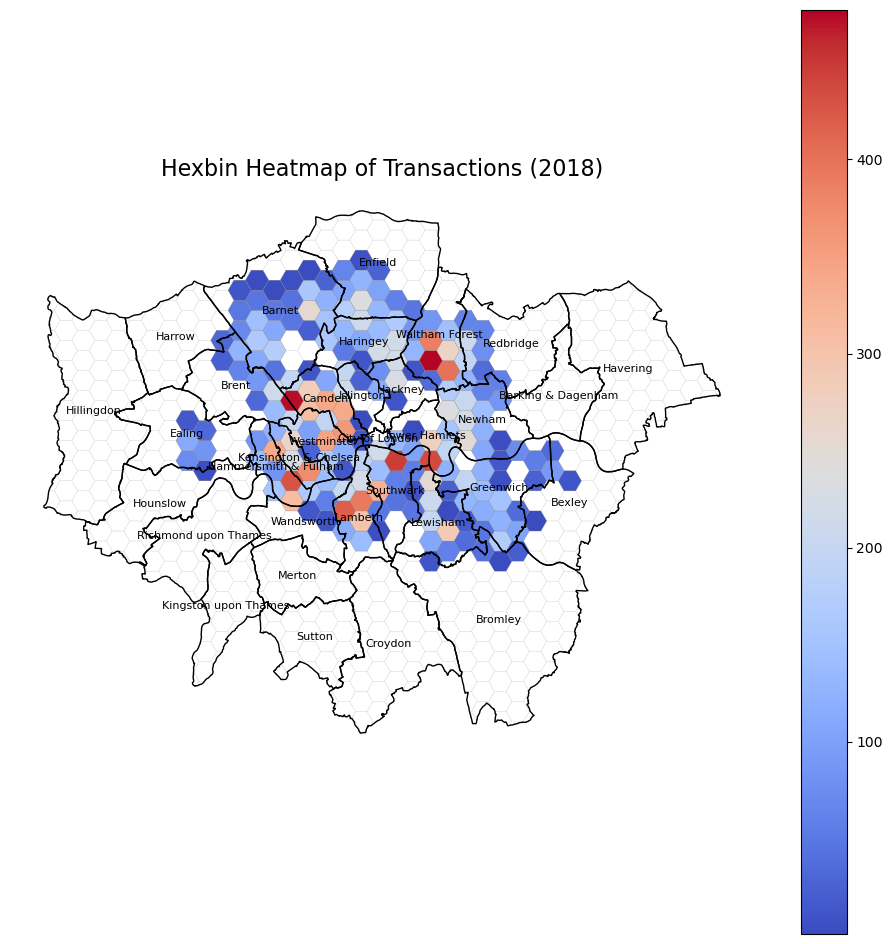

In [27]:
# Plot transactions heatmap
plot_transaction_heatmap(
    gdf=gdf,
    hexgrid=hexes,
    boroughs_path="./assets/London_Boroughs.shp",
    year=2018,
    hex_size=1000,
    cmap="coolwarm"
)